## [Week3] 모두의 주차장 앱 이용자 별 향후 이용건수 예측
### 주제: 앱 이용자 별 향후 이용 건수 예측 
### 목적: 이용자 별 향후 이용 건수를 예측하여 마케팅, 영업 등의 의사 결정 과정에 활용
### 모델 개발 요건: 이용자 별 결제 이력을 바탕으로 한 향후 한 달간 이용 건수 예측 

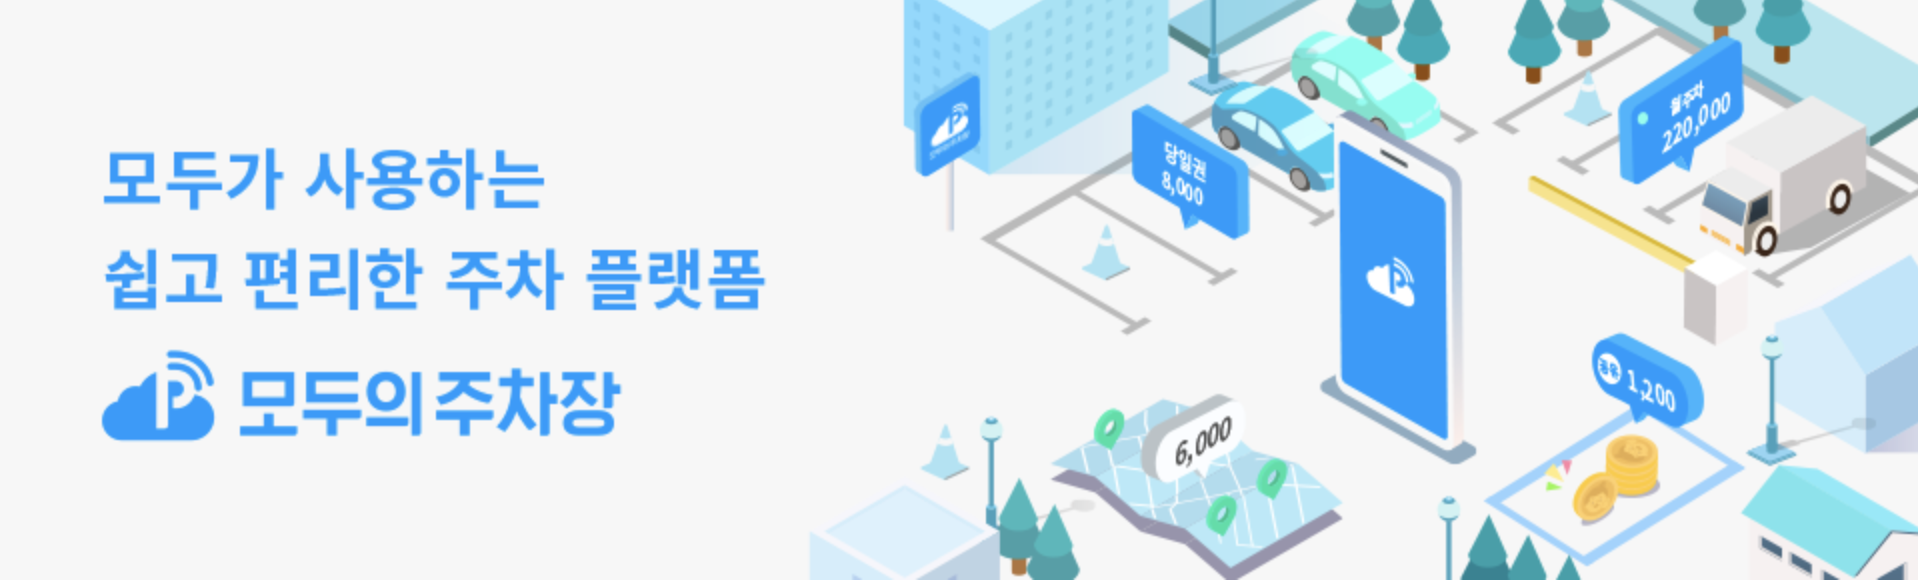

## 모두의 주차장
### 모바일을 통한 위치기반 주차장 정보 안내 및 주차공간 공유 서비스
URL: https://www.moduparking.com/
#### 주차장 정보 안내
- 서울 및 광역시 내 공영/민영/부설주차장 정보 제공
- 유료 주차장의 무료개방 시간을 실시간으로 반영해 안내
- 네비게이션 앱 연동 (Tmap, 네이버 지도, 카카오네비, 원내비, 맵피, 아틀란 3D 지원)
- 무료주차공간 정보 제공

#### 유휴 주차공간 공유
- 거주자 우선 주차, 사무건물, 빌라, 교회 등 주차면의 쓰지 않는 시간을 다른 운전자들에게 공유
- 공유할 시간(요일 및 시간)을 자유롭게 설정 가능
- '21년 2월 기준' 서울시 내 23개, 부산시 8개 자치구, 부천시와 주차공유사업 업무협약 체결

#### 주차요금 결제
- 공유주차장 및 제휴주차장 요금을 모바일로 결제하여 이용 (공영주차장은 제외)

#### 그밖에 정보 
- 2015년 '한국 구글플레이를 빛낸 베스트 앱' 선정
- 2014년 대한민국 인터넷대상 ‘국무총리상' (인터넷 사회진흥부문)
- 2013년 데모데이 '2014년을 빛낸 스타트업 TOP100' 선정
- 2013년 대한민국 모바일 앱어워드 '혁신상' 및 '으뜸앱' 선정
- 2013년 서울시 지정 ‘공유기업' 및 '주차공유 사업 시범 사업자’ 선정

#### Data 정의 
- Input: Tabular 데이터
- 2020.01.01 ~ 2020.12.31
- Output: Regression (향후 이용 건수 예측)

#### Task 정의
- Regression, 유저별 한 달후 이용 건수 예측 

#### Metric 정의
- MSE(평균제곱오차), MAE(평균절대오차)

#### 데이터 수집
- 유저 가입 정보: id, 가입일
- 소비 행동 정보: 상품id, 점포 주소, 결제일, 결제건수
- 외부 정보: 서울시 지점별 교통량 데이터 기온, 강수량, 풍속 등 기상데이터

In [1]:
# 패키지 import 
import pandas as pd
import numpy as np

# 그래프 관련 패키지 import 
import matplotlib.pyplot as plt  # mpatplotlib.pyplot
%matplotlib inline
from matplotlib.gridspec import GridSpec
import matplotlib.dates as mdates #  그래프의 원하는 날짜 형식으로 포멧 셋팅 Matplotlib.dates
import matplotlib.animation as animation # 그래프 애니메이션 효과 셋팅 Matplotlib.animation
import missingno as msno # 결측치 그래프 확인 missingno 패키지

import seaborn as sns
sns.set_style('darkgrid') # seaborn 그래프 background 회색으로 설정 
sns.set_context('talk') # 컨텍스트 매개 변수를 변경 플롯의 레이블에 대한 기본 글꼴 크기를 제어하는데 사용
sns.set(font_scale = 1)

import plotly.express as px # plotly.express
import plotly.io as pio # plotly 라이브러리를 표기하기 위해 추가한 코드 
pio.renderers.default = "notebook_connected"


# 모델링 관련 패키지 import 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import warnings   # 버전 충돌로 나오는 경고 표시를 표시하지 않게 설정 
warnings.filterwarnings('ignore')

from matplotlib import font_manager, rc   
# plt.rcParams['font.family'] = 'Malgun Gothic'  # (Windows 용) 한글 출력을 위한 글꼴 설정
plt.rcParams['font.family'] = 'AppleGothic'  # (MAC, 리눅스 용)
plt.rcParams['axes.unicode_minus'] = False    # 문자 - (마이너스) 정상 출력을 위한 코드

from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

### 데이터 확인 

In [2]:
# 실전 데이터 DB 
df_db = pd.read_csv('data/실전db.csv')
df_db.head(5)

,USER_ID,JOIN_DATE,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
0,2858,2014-01-07,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,AA,220691,C,2020-01-01,1,JRR


In [3]:
# 데이터프레임 재설정
# 1. JOIN DATE와 DATE 컬럼을 "-"를 기준으로 분할
join_date_list = df_db['JOIN_DATE'].str.split("-")

# 가입일자의 년도와 월을 생성
df_db['JOIN_YEAR'] = join_date_list.str.get(0)
df_db['JOIN_MONTH'] = join_date_list.str.get(1)

# 컬럼 재설정 
df_db = df_db[['USER_ID', 'JOIN_DATE', 'JOIN_YEAR', 'JOIN_MONTH', 'D_TYPE', 'STORE_ID', 'GOODS_TYPE', 
               'DATE', 'COUNT', 'AD1']]
df_db.head(5)

,USER_ID,JOIN_DATE,JOIN_YEAR,JOIN_MONTH,D_TYPE,STORE_ID,GOODS_TYPE,DATE,COUNT,AD1
0,2858,2014-01-07,2014,01,AA,1892,A,2020-01-01,1,GN
1,5647,2014-02-14,2014,02,BB,182009,A,2020-01-01,1,J
2,33314,2014-11-20,2014,11,BB,82431,A,2020-01-01,1,SC
3,37001,2014-12-04,2014,12,BB,725,C,2020-01-01,1,MP
4,37819,2014-12-07,2014,12,AA,220691,C,2020-01-01,1,JRR


In [4]:
# 1. DATE 컬럼을 "-"를 기준으로 분할
pay_date_list = df_db['DATE'].str.split("-")

# 가입일자의 년도와 월을 생성
df_db['PAY_YEAR'] = pay_date_list.str.get(0)
df_db['PAY_MONTH'] = pay_date_list.str.get(1)

# 컬럼 재설정 
df_db = df_db[['USER_ID', 'JOIN_DATE', 'JOIN_YEAR', 'JOIN_MONTH', 'D_TYPE', 'STORE_ID', 'GOODS_TYPE', 
               'DATE', 'PAY_YEAR', 'PAY_MONTH', 'COUNT', 'AD1']]

In [5]:
df_db.head(5)

,USER_ID,JOIN_DATE,JOIN_YEAR,JOIN_MONTH,D_TYPE,STORE_ID,GOODS_TYPE,DATE,PAY_YEAR,PAY_MONTH,COUNT,AD1
0,2858,2014-01-07,2014,01,AA,1892,A,2020-01-01,2020,01,1,GN
1,5647,2014-02-14,2014,02,BB,182009,A,2020-01-01,2020,01,1,J
2,33314,2014-11-20,2014,11,BB,82431,A,2020-01-01,2020,01,1,SC
3,37001,2014-12-04,2014,12,BB,725,C,2020-01-01,2020,01,1,MP
4,37819,2014-12-07,2014,12,AA,220691,C,2020-01-01,2020,01,1,JRR


In [6]:
# 실전 데이터 DB 데이터 타입 확인 
df_db.dtypes

USER_ID        int64
JOIN_DATE     object
JOIN_YEAR     object
JOIN_MONTH    object
D_TYPE        object
STORE_ID       int64
GOODS_TYPE    object
DATE          object
PAY_YEAR      object
PAY_MONTH     object
COUNT          int64
AD1           object
dtype: object

In [7]:
# 실전DB 사이즈 확인
df_db.shape

(879271, 12)

In [8]:
# 외부 데이터 1 - 2020년 교통량 데이터
trafic = pd.read_excel('data/2020교통량통합.xlsx')
trafic.head(5)

,DATE,지점명,지점번호,방향,구분,0시,1시,2시,3시,4시,...,14시,15시,16시,17시,18시,19시,20시,21시,22시,23시
0,2020-01-01,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,712.0,645.0,437.0,309.0,290.0,...,1472.0,1416.0,1483.0,1329.0,1157.0,1014.0,954.0,849.0,780.0,480.0
1,2020-01-02,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,315.0,222.0,186.0,165.0,266.0,...,1792.0,1897.0,1842.0,2061.0,1994.0,1443.0,1233.0,1165.0,1094.0,852.0
2,2020-01-03,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,632.0,457.0,295.0,236.0,279.0,...,2004.0,1929.0,2049.0,2140.0,2178.0,1654.0,1356.0,1260.0,1253.0,941.0
3,2020-01-04,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,740.0,518.0,388.0,331.0,330.0,...,1837.0,1788.0,1588.0,1669.0,1530.0,1222.0,1143.0,1089.0,1039.0,791.0
4,2020-01-05,성산로(금화터널),A-01,유입,봉원고가차도->독립문역,533.0,424.0,297.0,230.0,209.0,...,1634.0,1673.0,1494.0,1429.0,1288.0,1035.0,987.0,884.0,803.0,564.0


In [9]:
# 교통량 통합 데이터 타입 확인 
trafic.dtypes

DATE    datetime64[ns]
지점명             object
지점번호            object
방향              object
구분              object
0시             float64
1시             float64
2시             float64
3시             float64
4시             float64
5시             float64
6시             float64
7시             float64
8시             float64
9시             float64
10시            float64
11시            float64
12시            float64
13시            float64
14시            float64
15시            float64
16시            float64
17시            float64
18시            float64
19시            float64
20시            float64
21시            float64
22시            float64
23시            float64
dtype: object

In [10]:
# trafic 데이터 사이즈
trafic.shape

(98820, 29)

In [11]:
# 외부 데이터 2 - 서울 기상 데이터 
weather = pd.read_csv('data/서울시_기상데이터.csv', encoding = 'cp949')

# 데이터프레임 재설정
# 1. 일시 컬럼을 띄어쓰기 기준으로 분할
date_list = weather['일시'].str.split(" ")

# 분할한 데이터를 날짜 시간이라는 컬럼으로 저장
weather['날짜'] = date_list.str.get(0)
weather['시간'] = date_list.str.get(1)

# 컬럼 재설정 
weather = weather[['지점', '날짜', '시간', '기온', '강수량', '풍속', '습도', '일조시간', '적설량', '지면온도',
                  '지중온도']]
weather

,지점,날짜,시간,기온,강수량,풍속,습도,일조시간,적설량,지면온도,지중온도
0,108,2020-01-01,1:00,-5.9,NaN,1.7,40,NaN,NaN,-2.4,3.2
1,108,2020-01-01,2:00,-5.7,NaN,0.1,42,NaN,NaN,-2.4,3.1
2,108,2020-01-01,3:00,-5.6,0.0,0.0,46,NaN,NaN,-2.7,3.1
3,108,2020-01-01,4:00,-5.4,NaN,0.0,50,NaN,NaN,-2.5,3.0
4,108,2020-01-01,5:00,-5.2,NaN,0.0,55,NaN,NaN,-2.2,3.0
...,...,...,...,...,...,...,...,...,...,...,...
8755,108,2020-12-30,20:00,-11.8,NaN,4.8,54,NaN,NaN,-6.5,2.2
8756,108,2020-12-30,21:00,-12.4,NaN,3.2,58,NaN,NaN,-6.9,2.2
8757,108,2020-12-30,22:00,-12.7,NaN,2.8,56,NaN,NaN,-7.1,2.1
8758,108,2020-12-30,23:00,-12.9,NaN,2.2,54,NaN,NaN,-7.3,2.1


In [12]:
# 서울시 기상 데이터 타입
weather.dtypes

지점        int64
날짜       object
시간       object
기온      float64
강수량     float64
풍속      float64
습도        int64
일조시간    float64
적설량     float64
지면온도    float64
지중온도    float64
dtype: object

In [13]:
# 서울시 기상 데이터 사이즈 
weather.shape

(8760, 11)

### Date를 Datetime으로 문자열을 숫자형으로 변환

In [14]:
df_db.JOIN_DATE = pd.to_datetime(df_db.JOIN_DATE)
df_db.JOIN_YEAR = pd.to_numeric(df_db.JOIN_YEAR)
df_db.JOIN_MONTH = pd.to_numeric(df_db.JOIN_MONTH)
df_db.DATE = pd.to_datetime(df_db.DATE)
df_db.PAY_YEAR = pd.to_numeric(df_db.PAY_YEAR)
df_db.PAY_MONTH = pd.to_numeric(df_db.PAY_MONTH)
trafic.DATE = pd.to_datetime(trafic.DATE)
weather.날짜 = pd.to_datetime(weather.날짜)

### EDA 데이터 탐색 

#### 결측치 확인 

In [15]:
# 결측치 확인하기
for i in df_db.columns:
    ab = df_db[i].isnull().sum()
    if ab < 100000:
        print(i + "has {} null values.".format(ab))
        print()

USER_IDhas 0 null values.

JOIN_DATEhas 0 null values.

JOIN_YEARhas 0 null values.

JOIN_MONTHhas 0 null values.

D_TYPEhas 0 null values.

STORE_IDhas 0 null values.

GOODS_TYPEhas 0 null values.

DATEhas 0 null values.

PAY_YEARhas 0 null values.

PAY_MONTHhas 0 null values.

COUNThas 0 null values.

AD1has 0 null values.



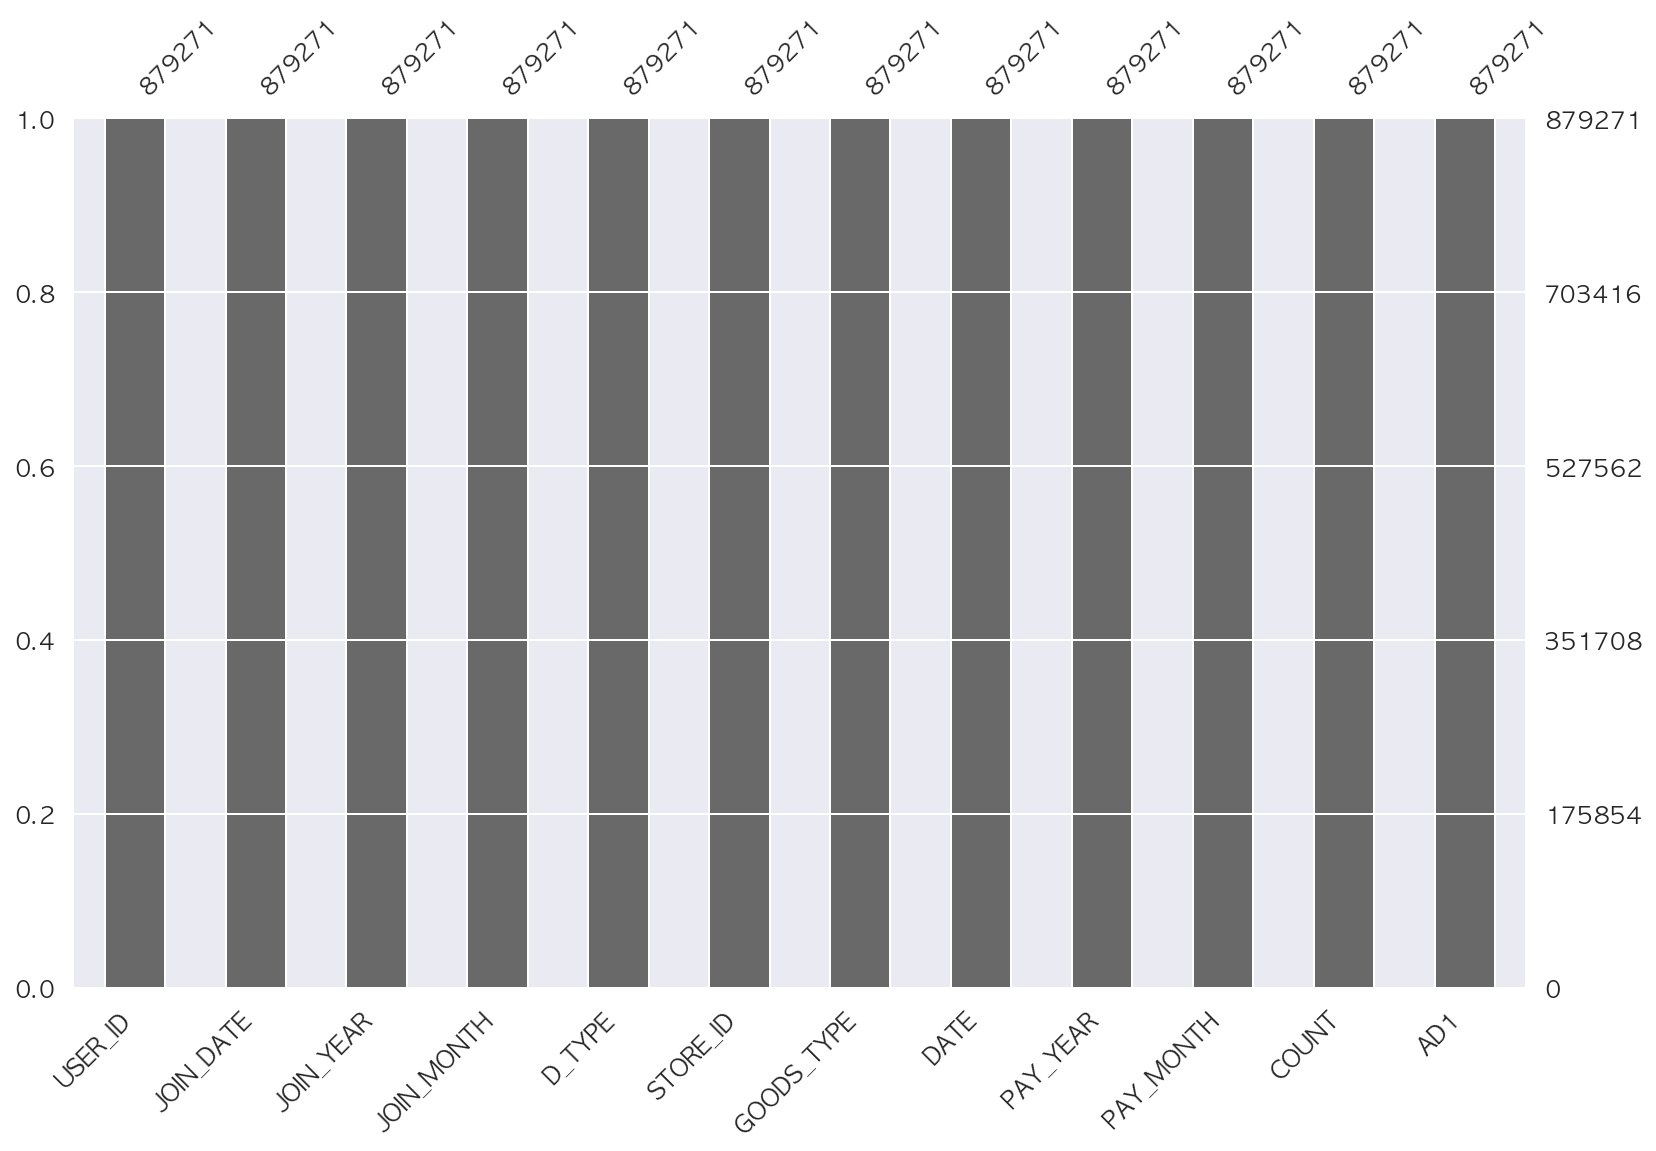

In [16]:
# 결측치 그래프 나타내기
msno.bar(df_db, fontsize=12, figsize=(13,8));

#### 컬럼정의
- USER_ID: 사용자ID 
- JOIN_DATE: 가입일자 
- JOIN_YEAR: 가입년도
- JOIN_MONTH: 가입월 
- D_TYPE: 구매타입(n시간권/당일권/월정액권)
- STORE_ID: 상품ID
- GOOD_TYPE: 상품타입
- DATE: 결제일
- PAY_YEAR: 결제년도
- PAY_MONTH: 결제월
- COUNT: 결제 건수 
- AD1: 점포 주소

In [17]:
# 각 column당 row 값 현황 정리 - unique
for col in df_db.columns:
    print(f"column : {col}")
    print(f"The number of unique : {df_db[col].nunique()}")  # nunique: 유니크한 value의 갯수를 나타내는 함수
    print()

column : USER_ID
The number of unique : 165425

column : JOIN_DATE
The number of unique : 2352

column : JOIN_YEAR
The number of unique : 9

column : JOIN_MONTH
The number of unique : 12

column : D_TYPE
The number of unique : 3

column : STORE_ID
The number of unique : 1061

column : GOODS_TYPE
The number of unique : 4

column : DATE
The number of unique : 366

column : PAY_YEAR
The number of unique : 1

column : PAY_MONTH
The number of unique : 12

column : COUNT
The number of unique : 56

column : AD1
The number of unique : 85



In [18]:
df_db['JOIN_YEAR'].unique()

array([2014, 2015, 2016, 2017, 2018, 2019, 1970, 2020, 2013])

In [19]:
# 가입 발생한 년도별 건수 분포 
year_1970_count = len(df_db[df_db['JOIN_YEAR']==1970])
year_2013_count = len(df_db[df_db['JOIN_YEAR']==2013])
year_2014_count = len(df_db[df_db['JOIN_YEAR']==2014])
year_2015_count = len(df_db[df_db['JOIN_YEAR']==2015])
year_2016_count = len(df_db[df_db['JOIN_YEAR']==2016])
year_2017_count = len(df_db[df_db['JOIN_YEAR']==2017])
year_2018_count = len(df_db[df_db['JOIN_YEAR']==2018])
year_2019_count = len(df_db[df_db['JOIN_YEAR']==2019])
year_2020_count = len(df_db[df_db['JOIN_YEAR']==2020])

print('1970년 기준 건수:', year_1970_count, '건')
print('2013년 기준 건수:', year_2013_count, '건')
print('2014년 기준 건수:', year_2014_count, '건')
print('2015년 기준 건수:', year_2015_count, '건')
print('2016년 기준 건수:', year_2016_count, '건')
print('2017년 기준 건수:', year_2017_count, '건')
print('2018년 기준 건수:', year_2018_count, '건')
print('2019년 기준 건수:', year_2019_count, '건')
print('2020년 기준 건수:', year_2020_count, '건')

1970년 기준 건수: 1093 건
2013년 기준 건수: 37 건
2014년 기준 건수: 2957 건
2015년 기준 건수: 14946 건
2016년 기준 건수: 32701 건
2017년 기준 건수: 79938 건
2018년 기준 건수: 140523 건
2019년 기준 건수: 257603 건
2020년 기준 건수: 349473 건


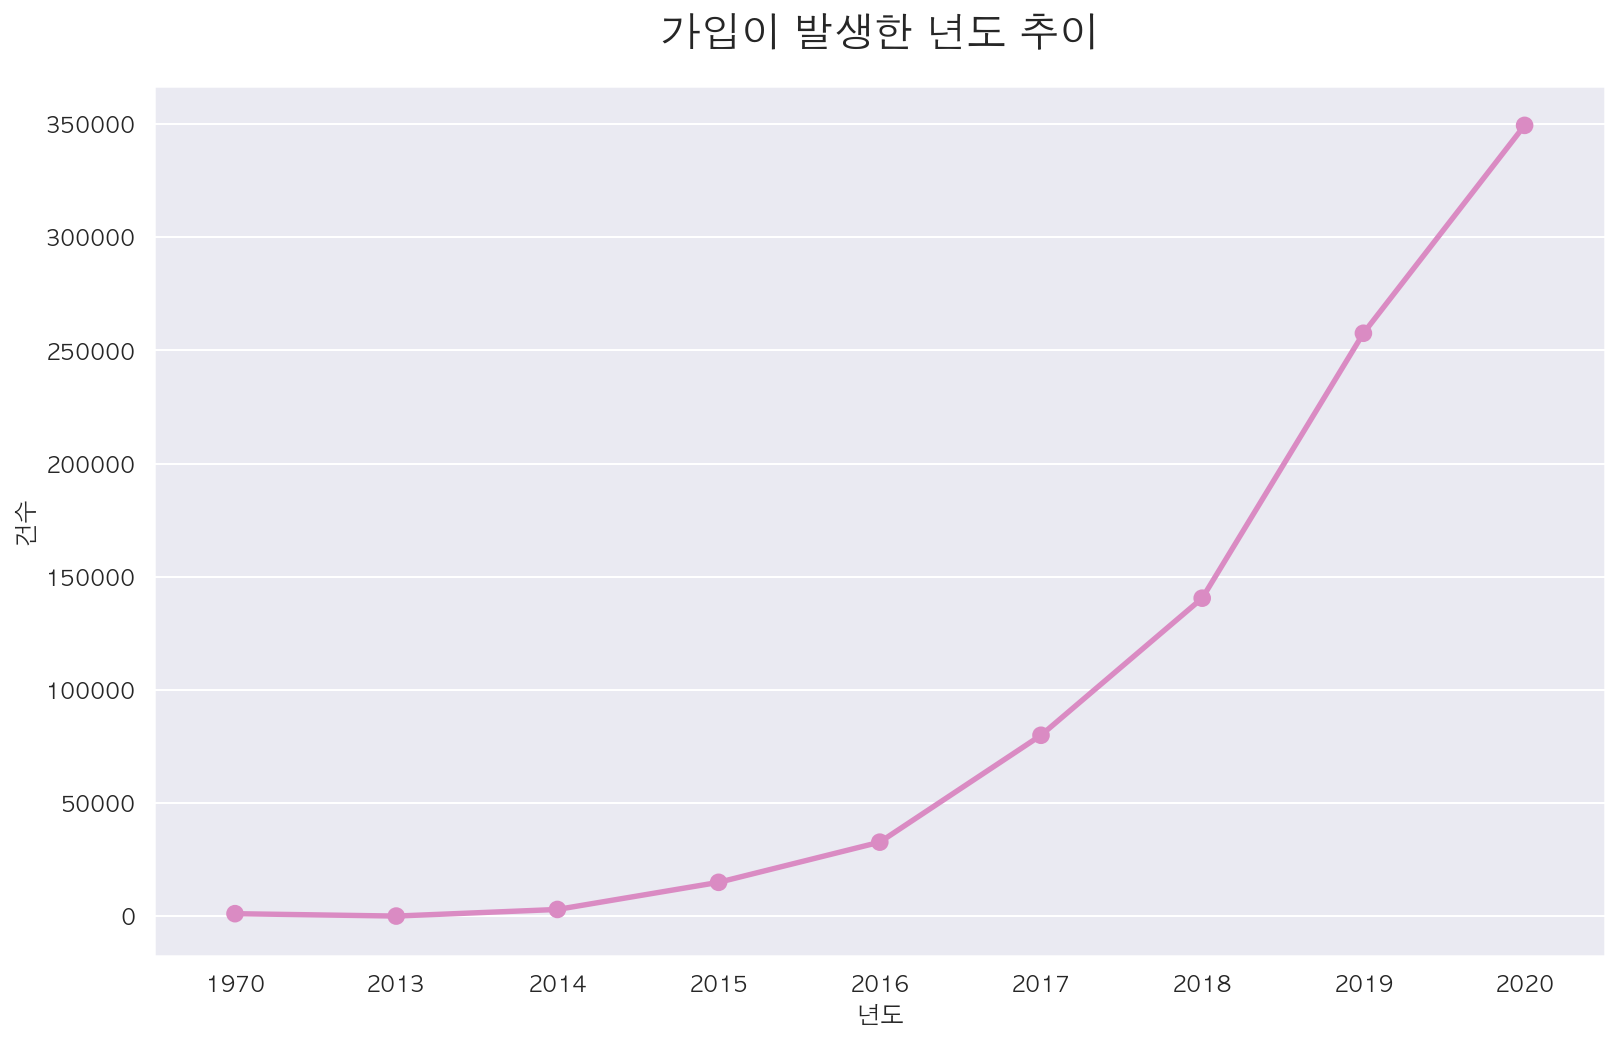

In [20]:
# 그래프로 나타내보기
df_year = pd.DataFrame({'year': [1970, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
                       'case': [1093, 37, 2957, 14946, 32701, 79938, 140523, 257603, 349473],
                       })

plt.figure(figsize=[13,8])
sns.pointplot(data=df_year, x='year', y="case", color=sns.color_palette()[6])
plt.title("가입이 발생한 년도 추이", fontsize=20, pad=20);
plt.xlabel('년도')
plt.ylabel('건수')
plt.show()

- 데이터는 1970년 부터 2020년 까지 있다.
- 해마다 가입수는 증가함
- 그런데 1970년도가 있어 의아하다. - 해당 데이터가 어떤것인지 조사가 필요함

In [21]:
df_db[df_db['JOIN_YEAR']==1970]

,USER_ID,JOIN_DATE,JOIN_YEAR,JOIN_MONTH,D_TYPE,STORE_ID,GOODS_TYPE,DATE,PAY_YEAR,PAY_MONTH,COUNT,AD1
437,1081430,1970-01-01,1970,1,CC,90070,A,2020-01-01,2020,1,1,GD
2196,1410151,1970-01-01,1970,1,CC,92437,B,2020-01-02,2020,1,1,J
2204,1415023,1970-01-01,1970,1,CC,131081,A,2020-01-02,2020,1,1,YO
2434,125582,1970-01-01,1970,1,CC,91885,A,2020-01-03,2020,1,1,YD
2645,602188,1970-01-01,1970,1,CC,2334,B,2020-01-03,2020,1,1,MP
...,...,...,...,...,...,...,...,...,...,...,...,...
866536,1723400,1970-01-01,1970,1,CC,190188,A,2020-12-26,2020,12,1,JR
867913,1723400,1970-01-01,1970,1,CC,190188,A,2020-12-27,2020,12,1,JR
868210,1825656,1970-01-01,1970,1,CC,219936,A,2020-12-27,2020,12,1,YD
873707,1828010,1970-01-01,1970,1,CC,220635,C,2020-12-29,2020,12,1,GN


In [22]:
# 결제가 발생한 년도별 건수 분포 
pay_year_2020_count = len(df_db[df_db['PAY_YEAR']==2020])

print('2020년 결제 기준 건수:', pay_year_2020_count, '건')

2020년 결제 기준 건수: 879271 건


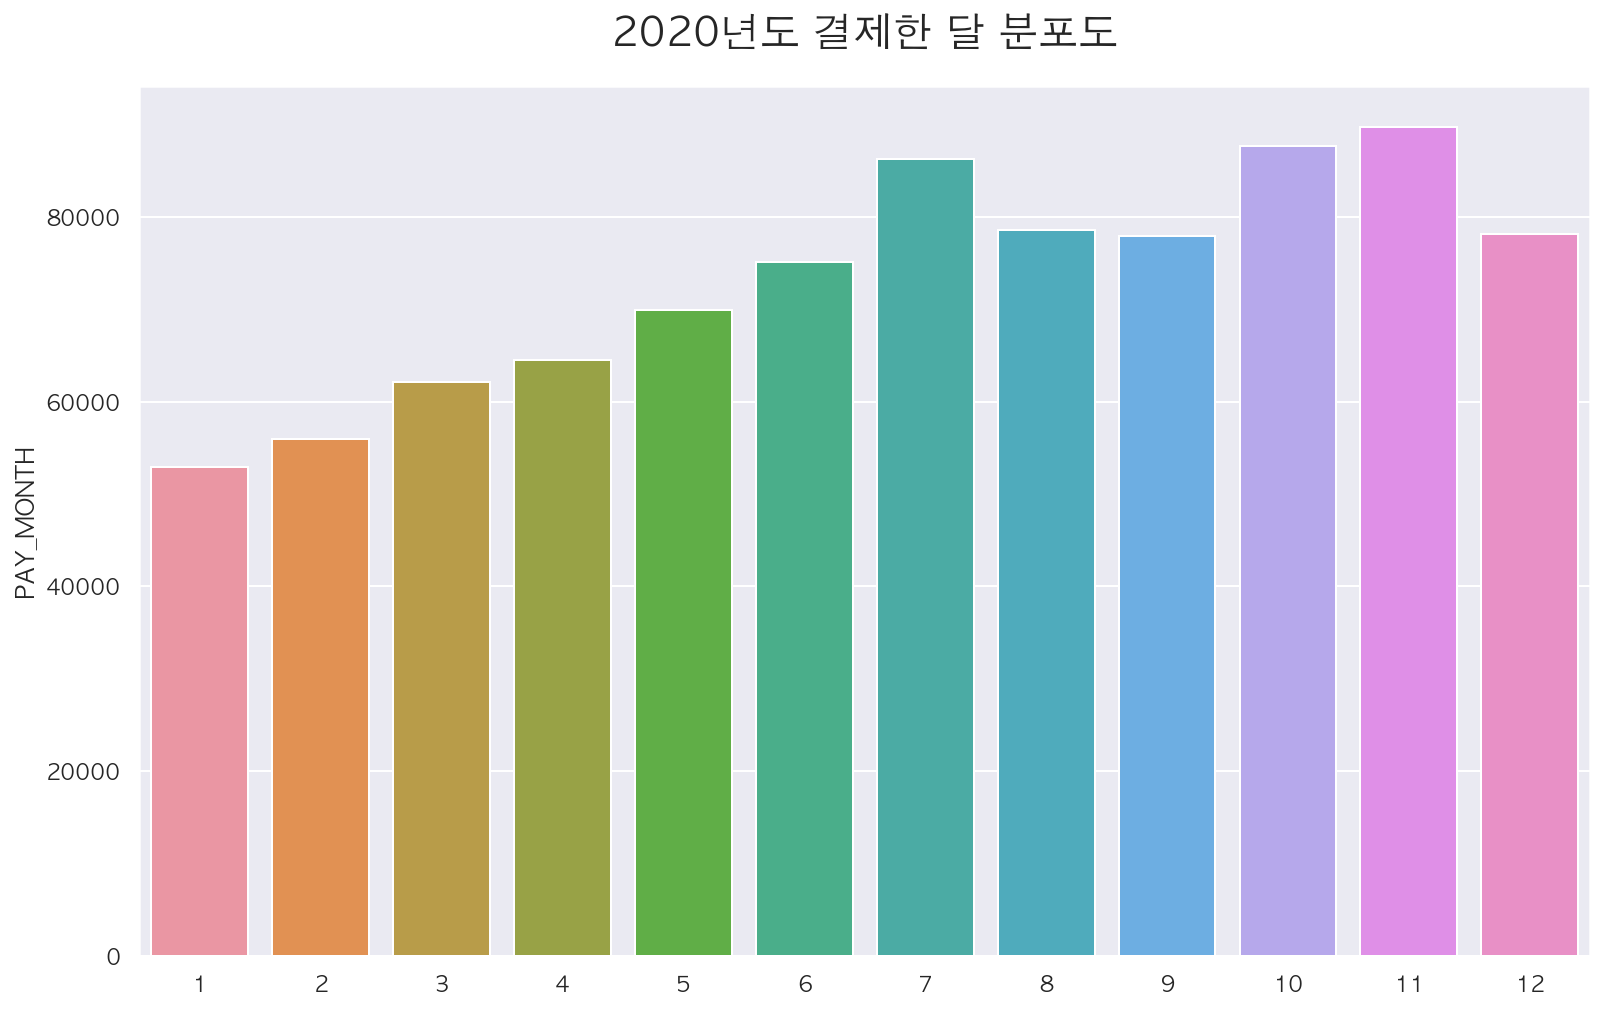

In [23]:
pay_month = pd.DataFrame(df_db['PAY_MONTH'].value_counts().sort_index())

plt.figure(figsize=(13, 8))
plt.title("2020년도 결제한 달 분포도", fontsize=20, pad=20)
sns.barplot(data=pay_month, x=pay_month.index, y="PAY_MONTH")
plt.show()

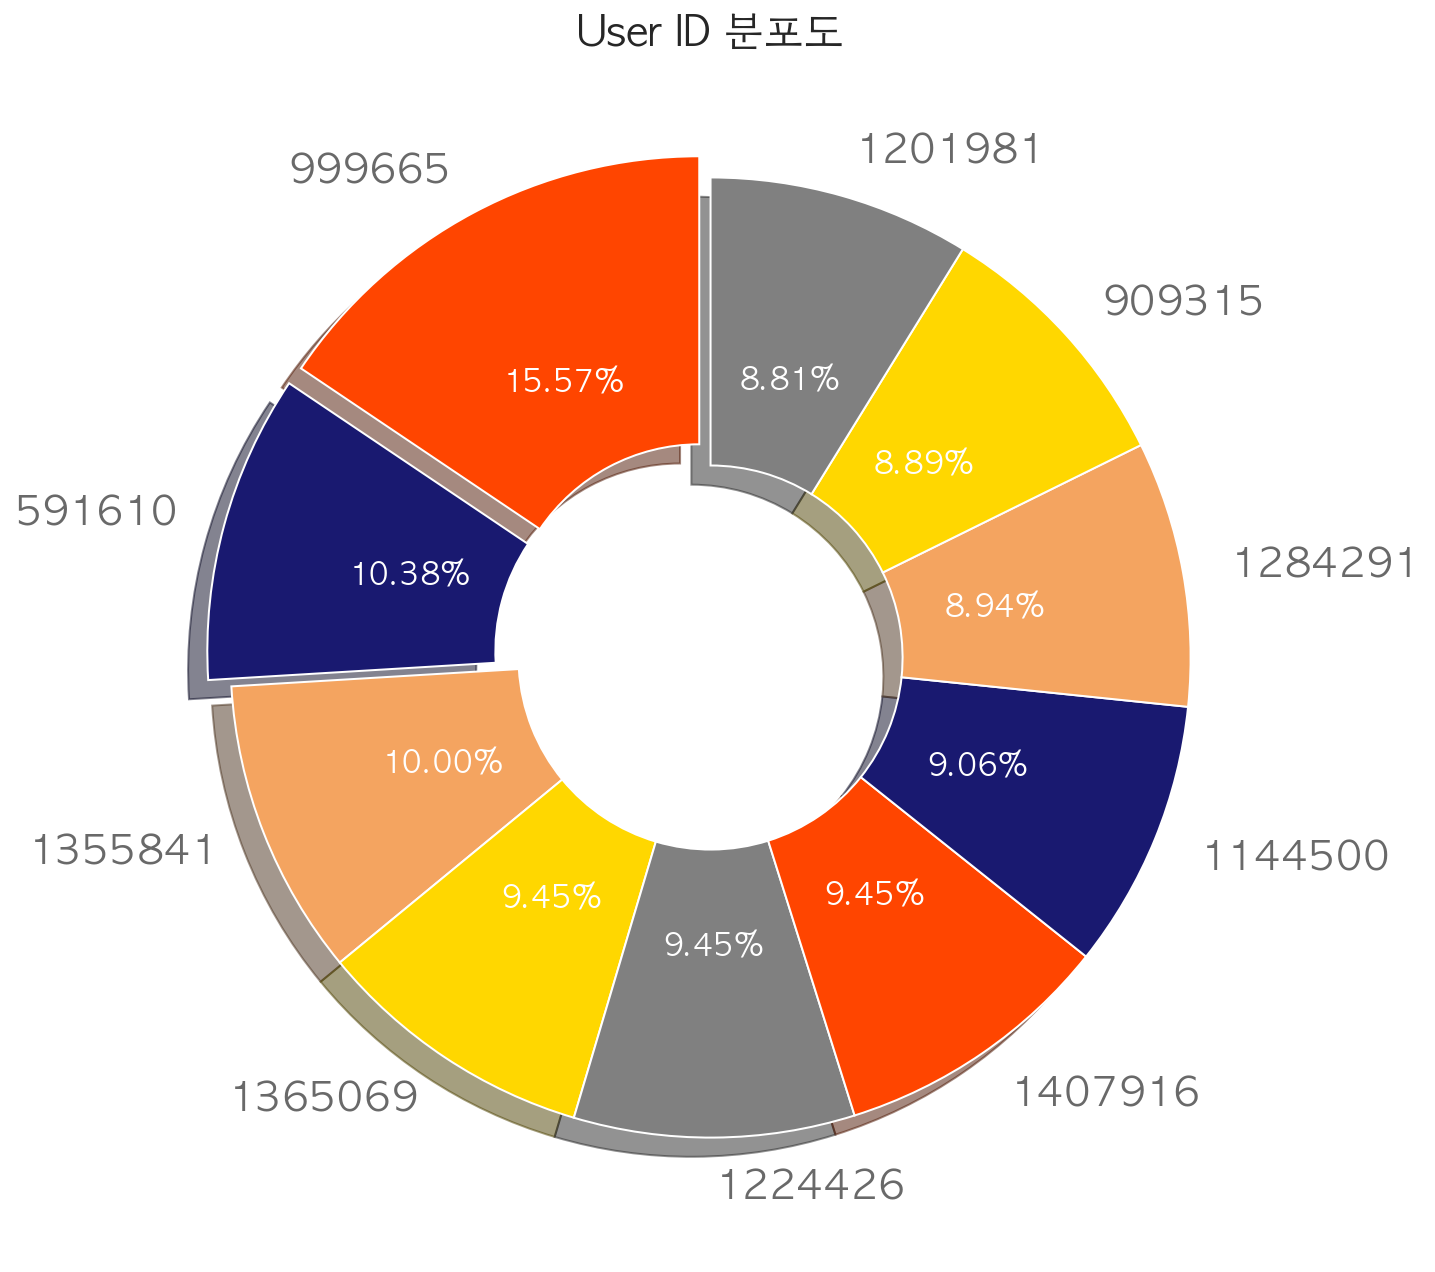

In [25]:
# User ID 분포 차트로 표현
user_id = pd.DataFrame(df_db['USER_ID'].value_counts())

labels = list(user_id['USER_ID'][:10].keys())## 라벨
frequency = list(user_id['USER_ID'][:10].values) ## 빈도
    
plt.figure(figsize=(13,9)) # 차트 사이즈 
explode = (0.05, 0.05, 0, 0, 0, 0, 0, 0, 0, 0)  # 튀어나오는 정도 결정 
colors = ['orangered','midnightblue','sandybrown', 'gold', 'gray', 'orangered','midnightblue',
          'sandybrown', 'gold', 'gray']  
plt.title("User ID 분포도", fontsize=20)  # 차트 타이틀
patches, texts, autotexts = plt.pie(frequency, # 차트에 적용될 값
        explode=explode, # 특정 값 튀어나오게 강조
        labels=labels,    # 라벨 출력
        colors=colors,    # 색상 설정 
        autopct=lambda p : '{:.2f}%'.format(p) ,  # 퍼센테이지 출력
        shadow=True,     # 차트 그림자 부
        startangle=90,    # 시작점을 90도로 지정
        wedgeprops=dict(width=0.6) # 중간의 반지름 0.5 만큼 구멍을 냄
       )

## label만 변경해주기 
for t in texts:
    t.set_color("dimgrey")
    t.set_fontsize(20)
## pie 위의 텍스트를 다른 색으로 변경해주기 
for t in autotexts:
    t.set_color("white")
    t.set_fontsize(15)
plt.tight_layout()
plt.show()

In [26]:
ad = pd.DataFrame(df_db['AD1'].value_counts())
ad.index.unique

<bound method Index.unique of Index(['J', 'GN', 'JRR', 'SC', 'MP', 'YD', 'YO', 'GS', 'CY', 'BF', 'GJ', 'SD',
       'CD', 'GW', 'DM', 'GD', 'P', '0', 'DJ', 'GSN', 'Q', 'GBC', 'SOD', 'YC',
       'BJG', 'NO', 'SB', 'GB', 'R', 'WT', 'GGY', 'ZE', 'WF', 'GSW', 'JR',
       'GHN', 'BOI', 'GAY', 'IND', 'GGM', 'COI', 'SG', 'GEJ', 'GAS', 'GKP',
       'BHW', 'BUD', 'GYI', 'DB', 'GPJ', 'ABP', 'SOI', 'PJP', 'CCA', 'BI',
       'DIV', 'AOI', 'IYS', 'BO', 'CN', 'SJV', 'BP', 'CAS', 'VU', 'DOI', 'SDU',
       'ZP', 'QH', 'WH', 'QGI', 'DSO', 'GGC', 'EP', 'CU', 'CVB', 'X', 'WAE',
       'WOID', 'SP', 'RRR', 'ADS', 'VO', 'DY', 'NW', 'GR'],
      dtype='object')>

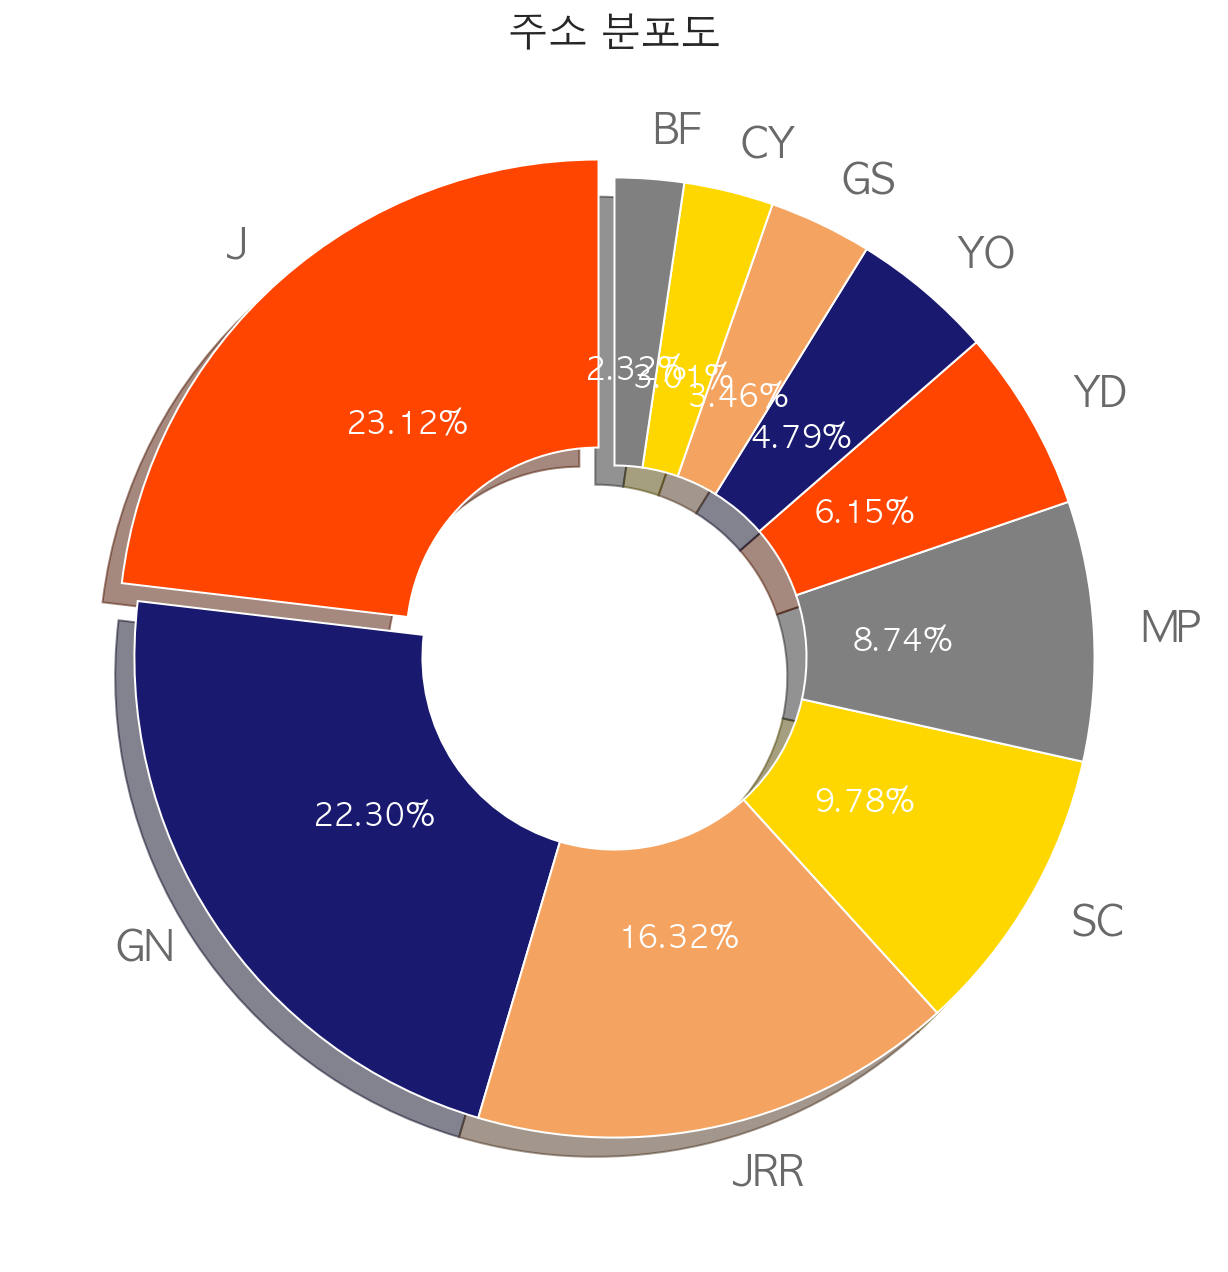

In [27]:
# 주소 분포 차트로 표현
labels = list(ad['AD1'][:10].keys())## 라벨
frequency = list(ad['AD1'][:10].values) ## 빈도
    
plt.figure(figsize=(13,9)) # 차트 사이즈 
explode = (0.05, 0, 0, 0, 0, 0, 0, 0, 0, 0)  # 튀어나오는 정도 결정 
colors = ['orangered','midnightblue','sandybrown', 'gold', 'gray', 'orangered','midnightblue',
          'sandybrown', 'gold', 'gray']  
plt.title("주소 분포도", fontsize=20)  # 차트 타이틀
patches, texts, autotexts = plt.pie(frequency, # 차트에 적용될 값
        explode=explode, # 특정 값 튀어나오게 강조
        labels=labels,    # 라벨 출력
        colors=colors,    # 색상 설정 
        autopct=lambda p : '{:.2f}%'.format(p) ,  # 퍼센테이지 출력
        shadow=True,     # 차트 그림자 부
        startangle=90,    # 시작점을 90도로 지정
        wedgeprops=dict(width=0.6) # 중간의 반지름 0.5 만큼 구멍을 냄
       )

## label만 변경해주기 
for t in texts:
    t.set_color("dimgrey")
    t.set_fontsize(20)
## pie 위의 텍스트를 다른 색으로 변경해주기 
for t in autotexts:
    t.set_color("white")
    t.set_fontsize(15)
plt.tight_layout()
plt.show()

- 가장 많은 지역은 'J'지역 이다 

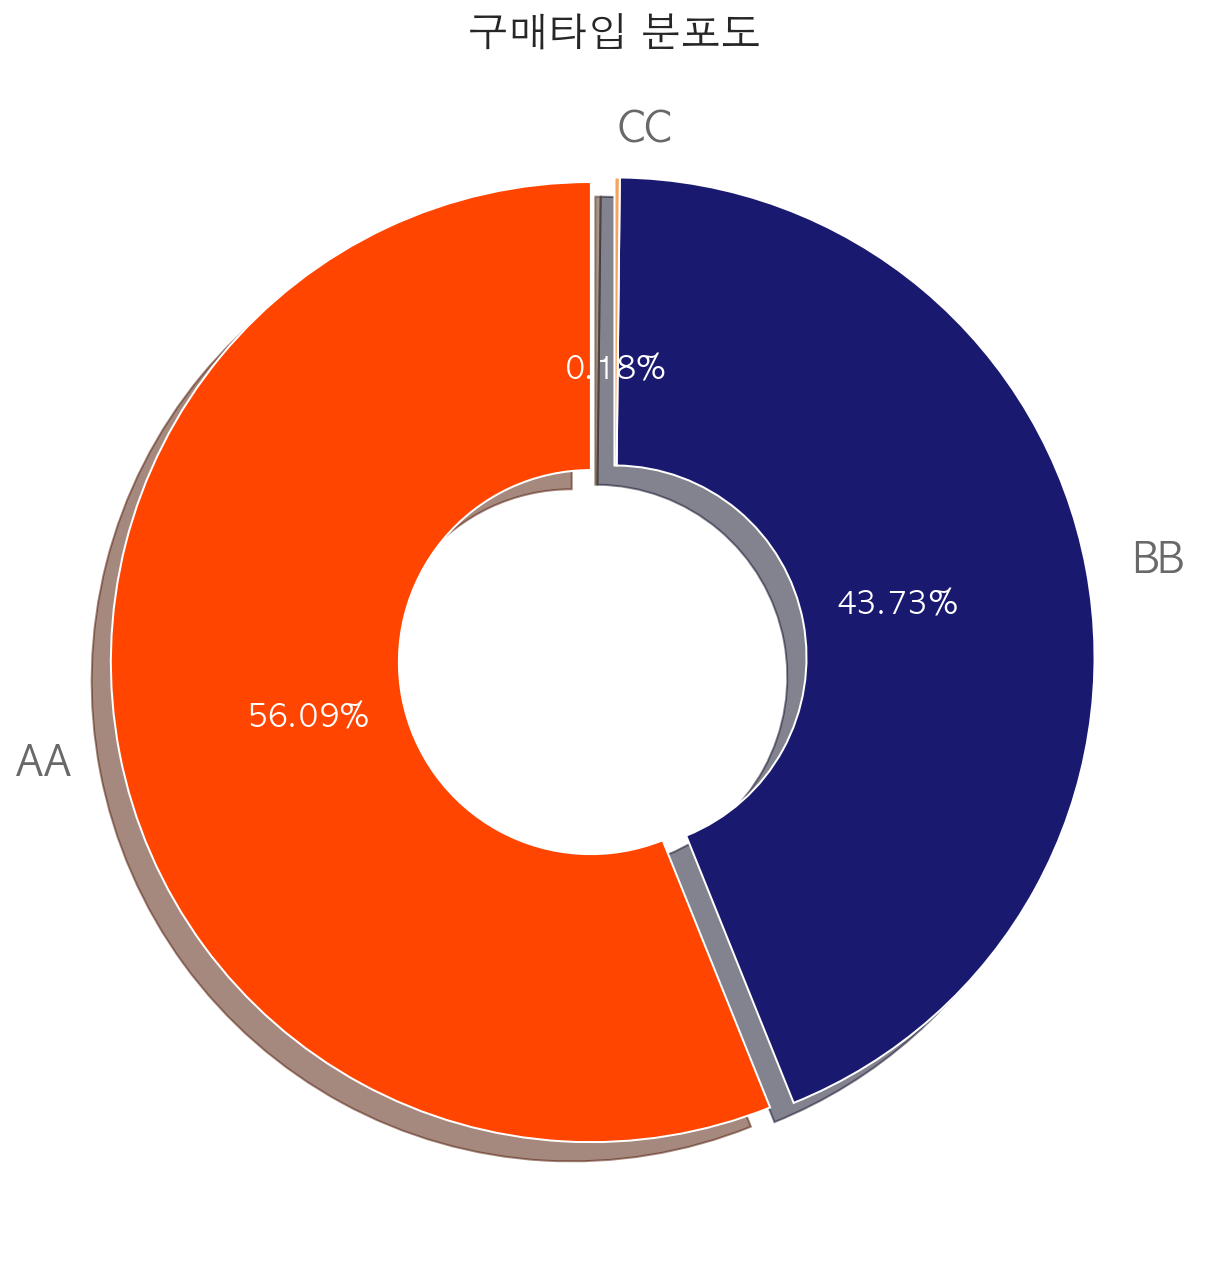

In [28]:
d_type = pd.DataFrame(df_db['D_TYPE'].value_counts())

labels = list(d_type['D_TYPE'][:].keys())## 라벨
frequency = list(d_type['D_TYPE'][:].values) ## 빈도
    
plt.figure(figsize=(13,9)) # 차트 사이즈 
explode = (0.05, 0, 0)  # 튀어나오는 정도 결정 
colors = ['orangered','midnightblue','sandybrown']  
plt.title("구매타입 분포도", fontsize=20)  # 차트 타이틀
patches, texts, autotexts = plt.pie(frequency, # 차트에 적용될 값
        explode=explode, # 특정 값 튀어나오게 강조
        labels=labels,    # 라벨 출력
        colors=colors,    # 색상 설정 
        autopct=lambda p : '{:.2f}%'.format(p) ,  # 퍼센테이지 출력
        shadow=True,     # 차트 그림자 부
        startangle=90,    # 시작점을 90도로 지정
        wedgeprops=dict(width=0.6) # 중간의 반지름 0.5 만큼 구멍을 냄
       )

## label만 변경해주기 
for t in texts:
    t.set_color("dimgrey")
    t.set_fontsize(20)
## pie 위의 텍스트를 다른 색으로 변경해주기 
for t in autotexts:
    t.set_color("white")
    t.set_fontsize(15)
plt.tight_layout()
plt.show()

- AA(시간권) 56.09%, BB(당일권) 43.73%, CC(월정액권) 0.18%

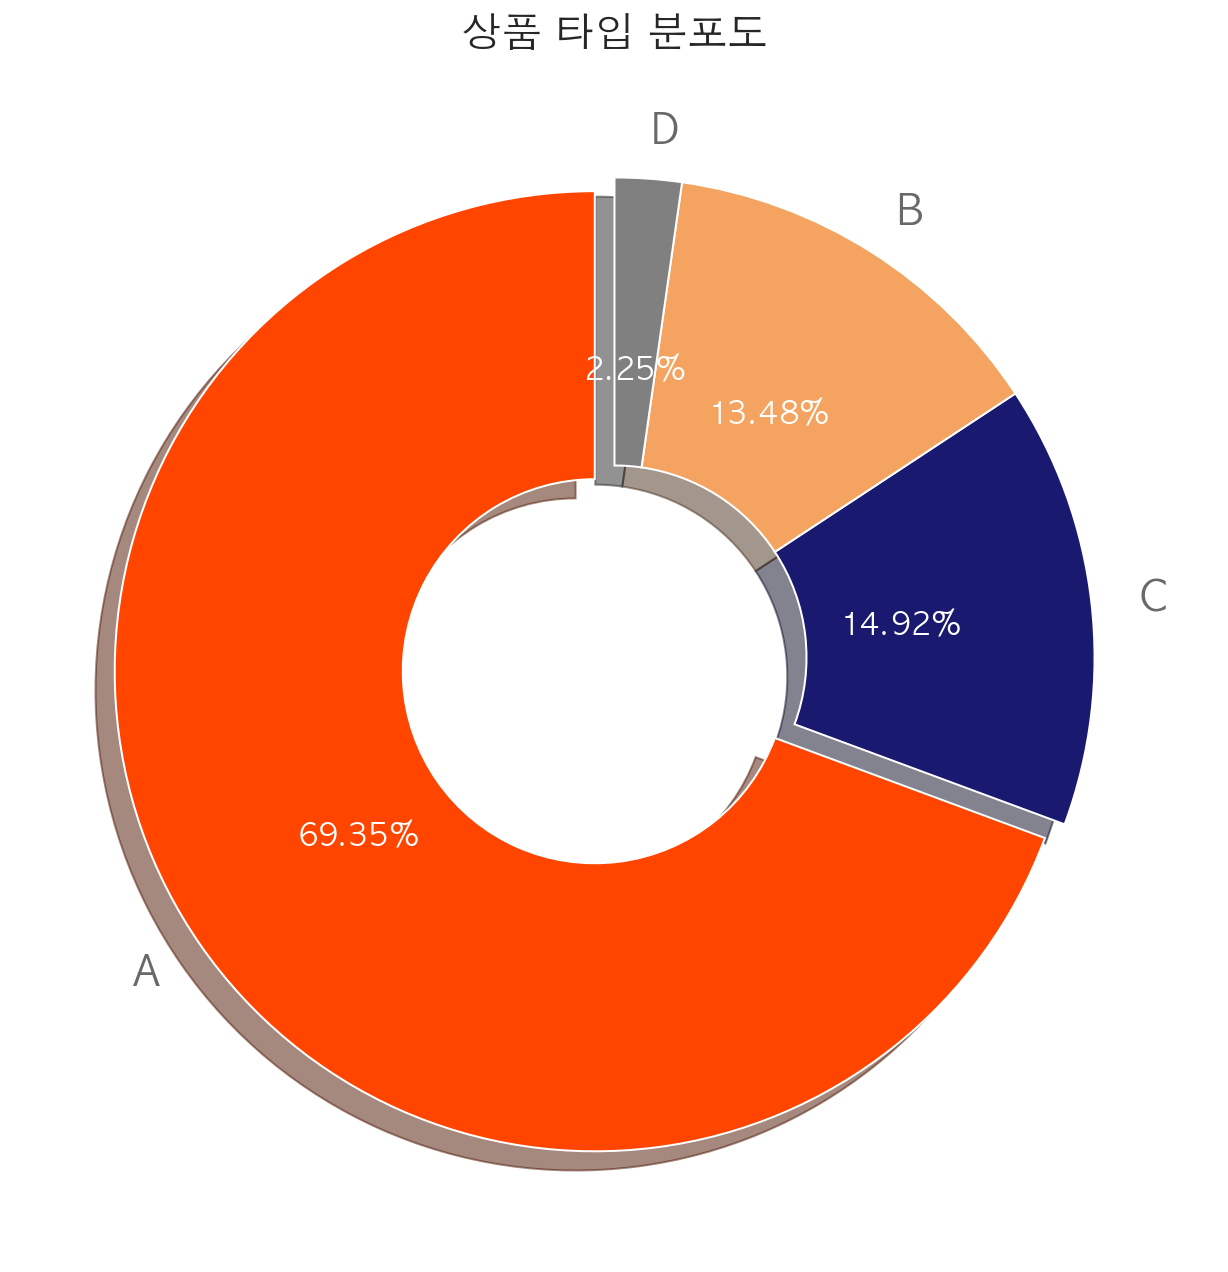

In [29]:
good_type = pd.DataFrame(df_db['GOODS_TYPE'].value_counts())

labels = list(good_type['GOODS_TYPE'][:].keys())## 라벨
frequency = list(good_type['GOODS_TYPE'][:].values) ## 빈도
    
plt.figure(figsize=(13,9)) # 차트 사이즈 
explode = (0.05, 0, 0, 0)  # 튀어나오는 정도 결정 
colors = ['orangered','midnightblue','sandybrown', 'gray']  
plt.title("상품 타입 분포도", fontsize=20)  # 차트 타이틀
patches, texts, autotexts = plt.pie(frequency, # 차트에 적용될 값
        explode=explode, # 특정 값 튀어나오게 강조
        labels=labels,    # 라벨 출력
        colors=colors,    # 색상 설정 
        autopct=lambda p : '{:.2f}%'.format(p) ,  # 퍼센테이지 출력
        shadow=True,     # 차트 그림자 부
        startangle=90,    # 시작점을 90도로 지정
        wedgeprops=dict(width=0.6) # 중간의 반지름 0.5 만큼 구멍을 냄
       )

## label만 변경해주기 
for t in texts:
    t.set_color("dimgrey")
    t.set_fontsize(20)
## pie 위의 텍스트를 다른 색으로 변경해주기 
for t in autotexts:
    t.set_color("white")
    t.set_fontsize(15)
plt.tight_layout()
plt.show()

- 상품 A가 69.35%, 상품 C가 14.92%, 상품 B가 13.48%, 상품 D가 2.25%

In [30]:
ndf = df_db

,USER_ID,JOIN_DATE,JOIN_YEAR,JOIN_MONTH,D_TYPE,STORE_ID,GOODS_TYPE,DATE,PAY_YEAR,PAY_MONTH,COUNT,AD1
0,2858,2014-01-07,2014,1,AA,1892,A,2020-01-01,2020,1,1,GN
1,5647,2014-02-14,2014,2,BB,182009,A,2020-01-01,2020,1,1,J
2,33314,2014-11-20,2014,11,BB,82431,A,2020-01-01,2020,1,1,SC
3,37001,2014-12-04,2014,12,BB,725,C,2020-01-01,2020,1,1,MP
4,37819,2014-12-07,2014,12,AA,220691,C,2020-01-01,2020,1,1,JRR
...,...,...,...,...,...,...,...,...,...,...,...,...
879266,1830551,2020-12-31,2020,12,BB,219886,B,2020-12-31,2020,12,1,GN
879267,1830570,2020-12-31,2020,12,BB,82433,B,2020-12-31,2020,12,1,CY
879268,1830580,2020-12-31,2020,12,AA,92020,B,2020-12-31,2020,12,1,JRR
879269,1830589,2020-12-31,2020,12,BB,92437,B,2020-12-31,2020,12,1,J


In [31]:
# Feature Onehot Encoding
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

ndf = df_db

ndf['D_TYPE'] = le.fit_transform(ndf['D_TYPE'])
ndf['GOODS_TYPE'] = le.fit_transform(ndf['GOODS_TYPE'])
ndf['AD1'] = le.fit_transform(ndf['AD1'])

print(ndf['D_TYPE'].unique())
print(ndf['GOODS_TYPE'].unique())
print(ndf['AD1'].unique())

[0 1 2]
[0 2 1 3]
[40 50 64 53 52 81 38 82 44 31  4 22  0 14 54 19 80 65 32 45 23 61 30 43
 37 63 48 56 46 51 33 36 39 12 67  7  5 29 47 13 57 34 49 20 35 28 77 21
  3 16 41 70  1 24 75  6 84 27 58  8 83 62 59 25 69  9 78 10 71 15 68 66
 60 11 17 73 74 55 26 76 42 79 18  2 72]


In [32]:
ndf.drop(['USER_ID','JOIN_DATE', 'JOIN_YEAR', 'JOIN_MONTH', 'STORE_ID', 'DATE', 'PAY_YEAR', 'PAY_MONTH'],axis=1,inplace=True)

In [33]:
ndf

,D_TYPE,GOODS_TYPE,COUNT,AD1
0,0,0,1,40
1,1,0,1,50
2,1,0,1,64
3,1,2,1,53
4,0,2,1,52
...,...,...,...,...
879266,1,1,1,40
879267,1,1,1,19
879268,0,1,1,52
879269,1,1,1,50


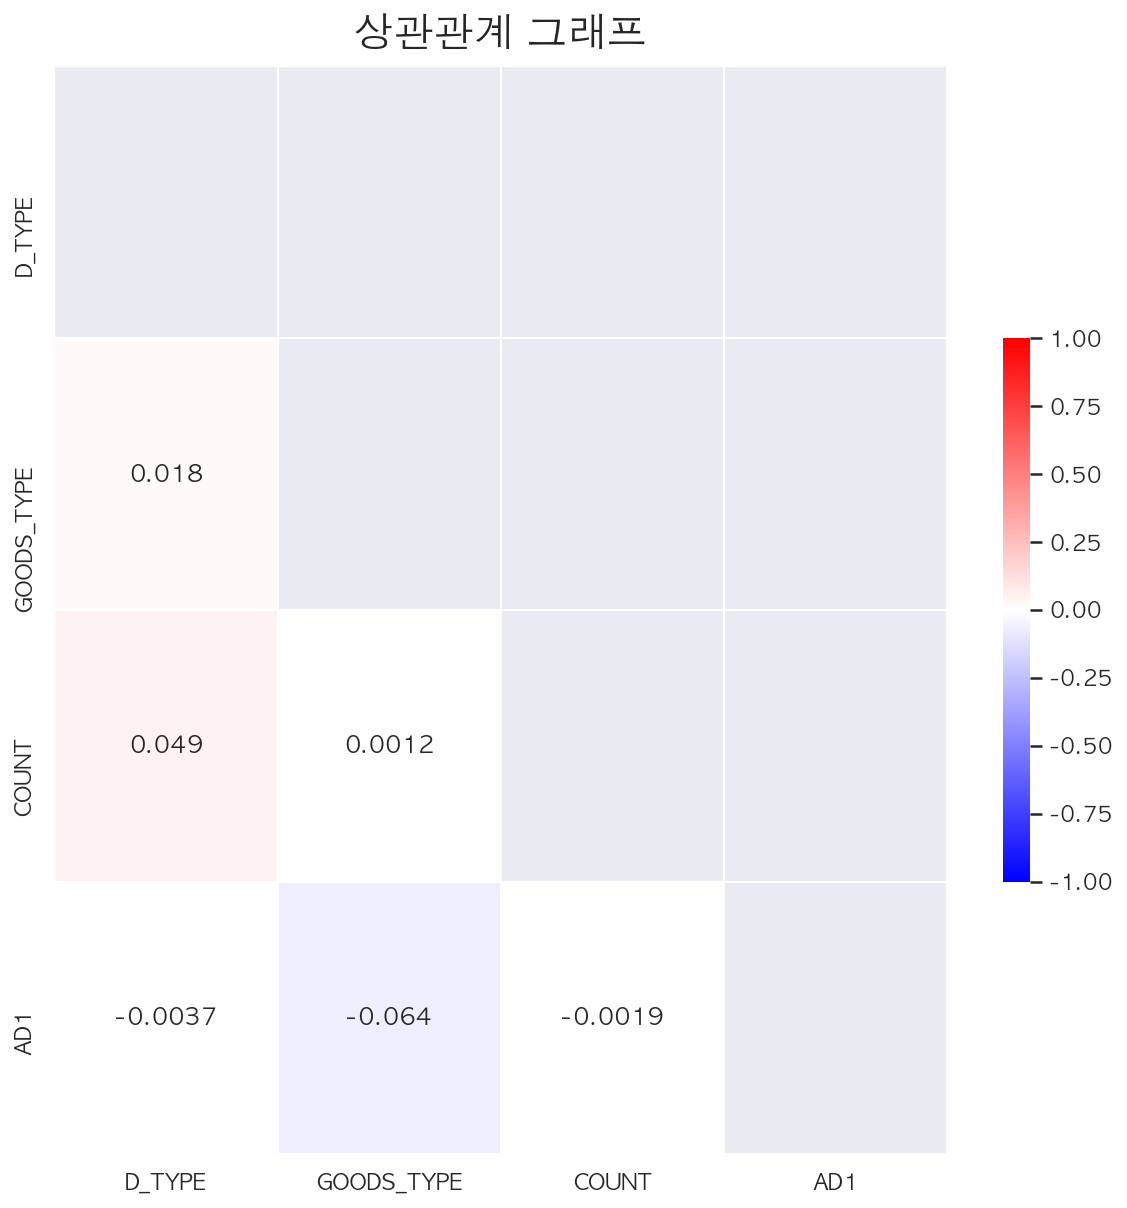

In [37]:
# 상관관계 그래프로 나타내기

a = ndf.corr()

# 사이즈 지정 
fig, ax = plt.subplots(figsize=(10, 10))

# 삼각형 마스크 만들기 (위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(a, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# 히트맵 그리기 
sns.heatmap(a, 
            cmap = 'bwr', 
            annot = True,   # 실제 값 표시
            mask=mask,      # 표시하지 않을 마스크 부분 지정 
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5}, # 컬러바 크기 젋반으로 줄이기 
            vmin = -1,vmax = 1    # 컬러바 범위 -1 ~ 1
           )  
plt.title('상관관계 그래프', fontsize=20, pad=10)
#sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
 #          square=True, linewidths=.5, annot=True)
plt.show()